In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Waste_Classification/Dataset_Resized"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
batch_size = 32
img_height = 150
img_width = 150
data_dir = '/content/drive/MyDrive/Waste_Classification/Dataset_Resized'

In [ ]:
dataset_size = tf.keras.preprocessing.image_dataset_from_directory(data_dir, batch_size = batch_size)

Found 4369 files belonging to 9 classes.


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 3496 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 873 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Aluminium', 'Cardboard', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']


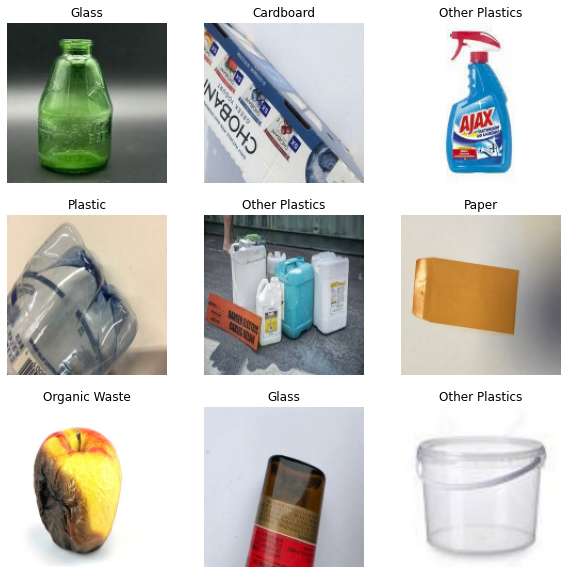

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(128, 3, activation='relu'),
  #layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation= 'softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


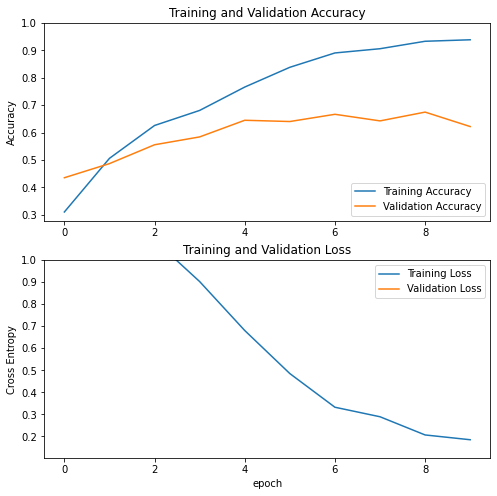

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
img_height = 150
img_width = 150

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2)
])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# define path to save model
model_path = './fm_cnn_BN.h5'
# prepare callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy', 
        patience=10,
        mode='max',
        verbose=1),
    ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]

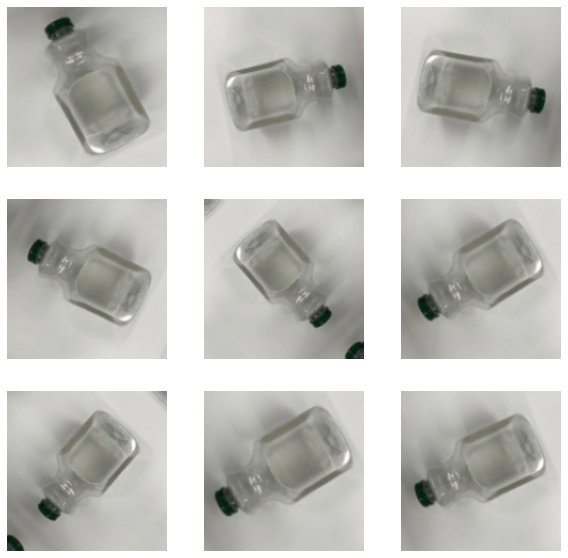

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  resize_and_rescale,

  layers.Conv2D(32, 3, activation='relu', strides = 2, input_shape=(150,150,3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides = 2),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides = 2),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(256, activation = 'relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),

  layers.Dense(9, activation = 'softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 100
history_fine = model.fit(x = train_ds,validation_data = val_ds,epochs=epochs, batch_size = 128)

Epoch 1/100
110/110 [==============================] - 7s 24ms/step - loss: 3880.1519 - accuracy: 0.1550 - val_loss: 279.4447 - val_accuracy: 0.1363
Epoch 2/100
110/110 [==============================] - 2s 21ms/step - loss: 269.1958 - accuracy: 0.1593 - val_loss: 262.4032 - val_accuracy: 0.1203
Epoch 3/100
110/110 [==============================] - 2s 21ms/step - loss: 253.5044 - accuracy: 0.1931 - val_loss: 245.4781 - val_accuracy: 0.1661
Epoch 4/100
110/110 [==============================] - 2s 21ms/step - loss: 241.8052 - accuracy: 0.1899 - val_loss: 238.8565 - val_accuracy: 0.1913
Epoch 5/100
110/110 [==============================] - 2s 21ms/step - loss: 236.6503 - accuracy: 0.2062 - val_loss: 234.8271 - val_accuracy: 0.2199
Epoch 6/100
110/110 [==============================] - 2s 21ms/step - loss: 234.4634 - accuracy: 0.2091 - val_loss: 234.5238 - val_accuracy: 0.2188
Epoch 7/100
110/110 [==============================] - 2s 22ms/step - loss: 234.8271 - accuracy: 0.2228 - val_l

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

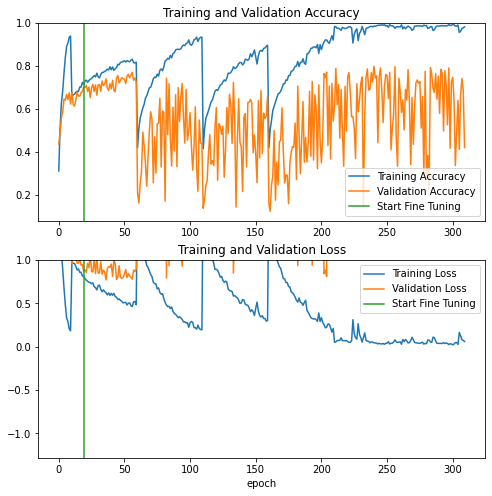

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([20-1,20-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()),1])
plt.plot([20-1,20-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)